<h1>PDIoT Data Analysis</h1>
<p>Hopefully by now you have collected some walking data. This comprises of 3-axis accelerometer and gyroscope data and can be explored further by using this Jupyter Notebook.</p>
<h2>Sensor types</h2>
<h3>Accelerometer</h3>
<ul>
    <li>Measures acceleration (including gravity)</li>
    <li>Observing the change in direction of gravity often more useful than linear acceleration due to movement</li>
    <li>Sensor values given in g along the axis of interest</li>
    <li>Placing our sensor flat on the table should give -1g on the Z axis and 0g on the other axes</li>
    <li>Cheap to buy and low power consumption</li>
</ul>
<h3>Gyroscope</h3>
<ul>
    <li>Directly measures rotational rate</li>
    <li>Unaffected by gravity direction or linear accelerations</li>
    <li>Sensor noise will cause drift if used to track orientation</li>
    <li>Sensor values given in degrees per second about the axis of interest</li>
    <li>Expensive to buy and much higher power consumption than accelerometer</li>
</ul>

<h2>Step Tracking</h2>

<p>Your are expected to research and develop the step counting algorithm yourselves during the course. A useful first stage  will be to look at the walking data visually to understand how the sensors react to different types of walking when mounted in different positions.</p>

<p>You are free to use any programming language for the data analysis part of the project, but we recommend using Python and Jupyter Notebook to quickly explore ideas. Below is a simple example using Python/Pandas to graph acceleration and gyroscope data from PDIoT walking data.</p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib notebook

In [4]:
def loadwalkingdata(filename):
    print("---- loading " + filename)
    with open(filename) as f:
        head = [next(f).rstrip().split('# ')[1] for x in range(10)]
        for l in head:
            print(l)
    print("----")
    return pd.read_csv(filename, header=11)

In [17]:
walk_wrist = loadwalkingdata("Group_K-J-walking-wrist.csv")
walk_foot = loadwalkingdata("Group_K-J-walking-foot.csv")
walk_arm = loadwalkingdata("Group_K-J-walking-upper_arm.csv")
walk_leg = loadwalkingdata("Group_K-J-walking-upper_leg.csv")

---- loading Group_K-J-walking-wrist.csv
PDIoT walking data"
Start time: 20190925T114619"
Group: K"
Subject: J"
Activity type: Walking (level ground)"
Sensor position: Wrist"
Side of body: Left"
Sensor mounting: Pocket"
Number of steps: 10"
Notes: "
----
---- loading Group_K-J-walking-foot.csv
PDIoT walking data"
Start time: 20190925T114250"
Group: K"
Subject: J"
Activity type: Walking (level ground)"
Sensor position: Foot"
Side of body: Left"
Sensor mounting: Pocket"
Number of steps: 10"
Notes: "
----
---- loading Group_K-J-walking-upper_arm.csv
PDIoT walking data"
Start time: 20190925T114538"
Group: K"
Subject: J"
Activity type: Walking (level ground)"
Sensor position: Upper arm"
Side of body: Left"
Sensor mounting: Pocket"
Number of steps: 10"
Notes: "
----
---- loading Group_K-J-walking-upper_leg.csv
PDIoT walking data"
Start time: 20190925T114205"
Group: K"
Subject: J"
Activity type: Walking (level ground)"
Sensor position: Upper Leg"
Side of body: Left"
Sensor mounting: Pocket"
N

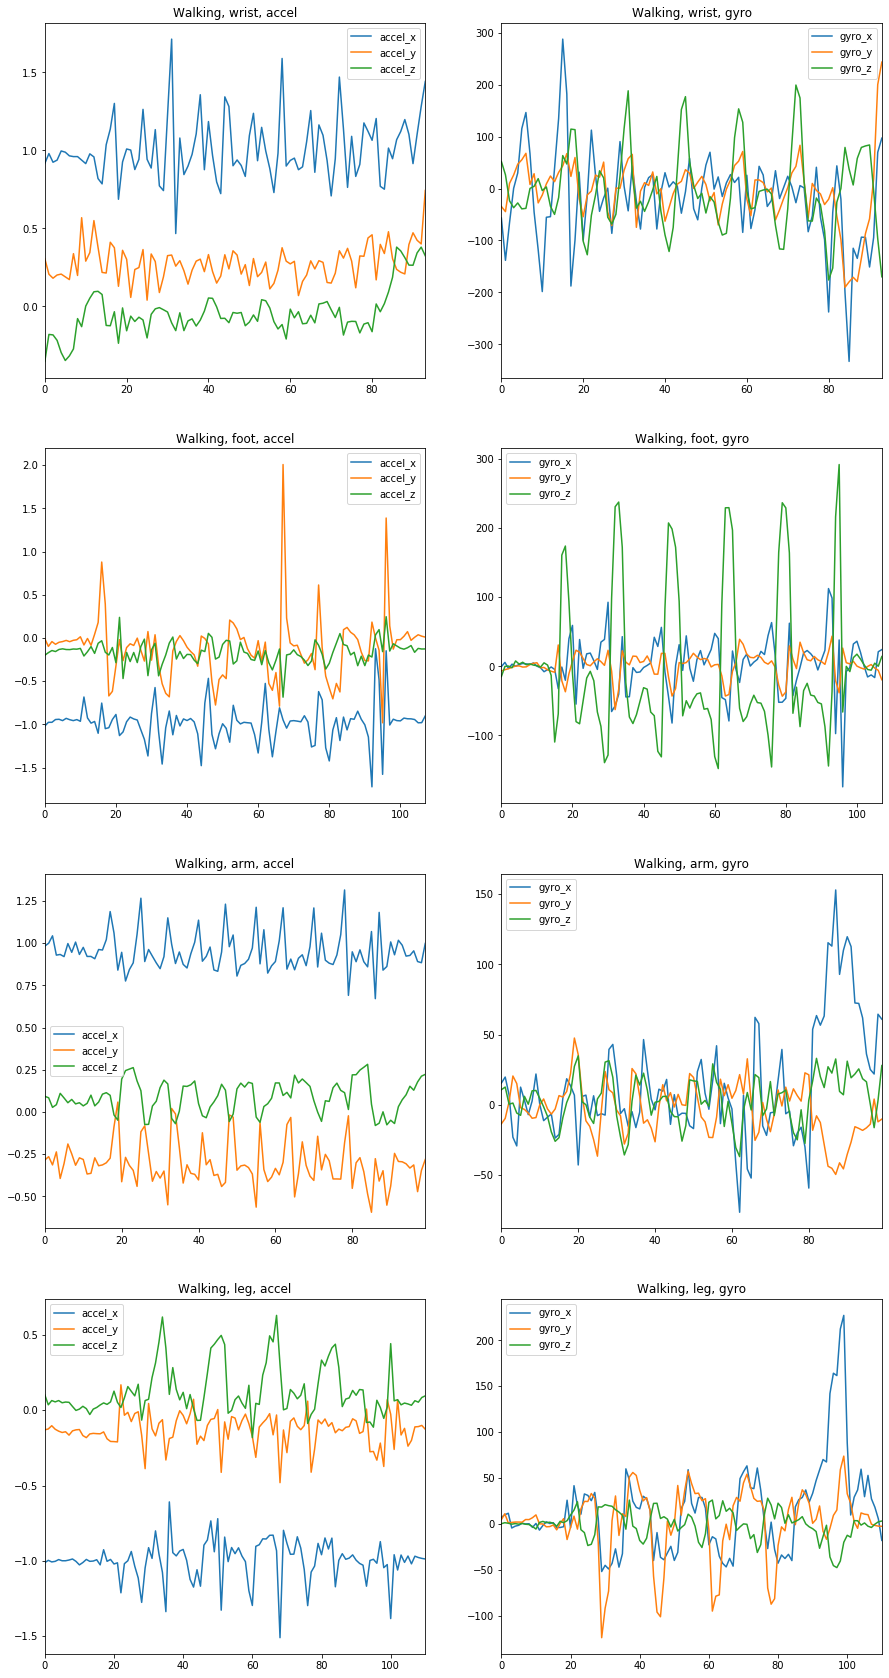

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,30))

walk_wrist.plot(y=['accel_x', 'accel_y', 'accel_z'], ax=axes[0,0], title="Walking, wrist, accel")
walk_wrist.plot(y=['gyro_x', 'gyro_y', 'gyro_z'], ax=axes[0,1], title="Walking, wrist, gyro")
walk_foot.plot(y=['accel_x', 'accel_y', 'accel_z'], ax=axes[1,0], title="Walking, foot, accel")
walk_foot.plot(y=['gyro_x', 'gyro_y', 'gyro_z'], ax=axes[1,1], title="Walking, foot, gyro")
walk_arm.plot(y=['accel_x', 'accel_y', 'accel_z'], ax=axes[2,0], title="Walking, arm, accel")
walk_arm.plot(y=['gyro_x', 'gyro_y', 'gyro_z'], ax=axes[2,1], title="Walking, arm, gyro")
walk_leg.plot(y=['accel_x', 'accel_y', 'accel_z'], ax=axes[3,0], title="Walking, leg, accel")
walk_leg.plot(y=['gyro_x', 'gyro_y', 'gyro_z'], ax=axes[3,1], title="Walking, leg, gyro")

Seems from the above that our best options are gyro on the foot (but that's going to be awkward from a physical perspective), gyro on the wrist and gyro on the upper leg. Let's try multiplying all the three axes together...

/usr/local/Caskroom/miniconda/base/envs/py3pdiot/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


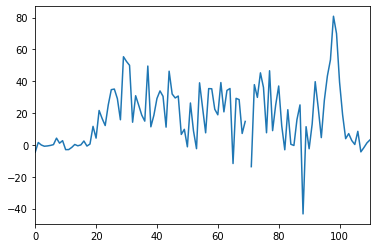

In [27]:
leg_gyro_abs = walk_leg[['gyro_x', 'gyro_y', 'gyro_z']].abs()
leg_gyro_prod = np.log(leg_gyro_abs).prod(1)
leg_gyro_prod.plot()

Nope, that's not gonna work... Let's take a look at the gyro for the wrist - seems like a safe bet given how many wearables use this source of data (Fitbit, Apple Watch and the like):

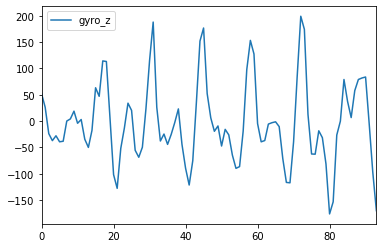

In [28]:
walk_wrist.plot(y=['gyro_z'])

Seems to be a little messy, as there's supposed to be 10 steps here, saying that, we didn't have a very long run so the last couple of steps might be a little subtle...

/usr/local/Caskroom/miniconda/base/envs/py3pdiot/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/py3pdiot/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


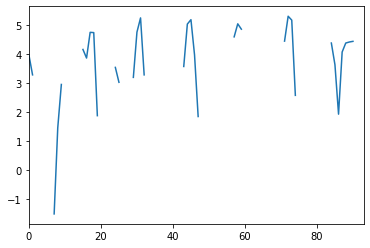

In [29]:
np.log(walk_wrist['gyro_z']).plot()

Lol yikes yeah forgot about the negative values. Let's go for a rather fancy sounding savitzky-golay-filter to smooth things out...

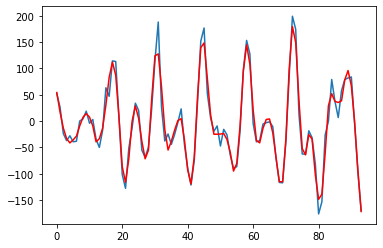

In [73]:
import scipy.signal

# https://riptutorial.com/scipy/example/15878/using-a-savitzky-golay-filter

y = walk_wrist['gyro_z']
yhat = scipy.signal.savgol_filter(y, 9, 4) # window size 51, polynomial order 3

plt.plot(y)
plt.plot(yhat, color='red')
plt.show()

In [74]:
import scipy.stats

iqr = scipy.stats.iqr(yhat)
print(iqr)

79.5753569347345


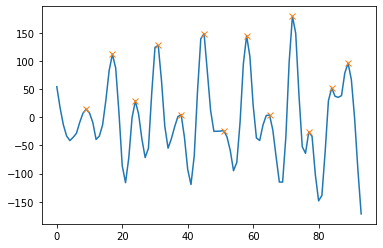

In [75]:
allpeaks = scipy.signal.find_peaks(yhat)
plt.plot(yhat)
plt.plot(allpeaks[0], yhat[allpeaks[0]], 'x')

In [76]:
peaks = scipy.signal.find_peaks(yhat, height=iqr)
print(peaks)

(array([17, 31, 45, 58, 72, 89]), {'peak_heights': array([112.15763403, 127.68968531, 148.56643357, 144.9775641 ,
       179.48317308,  96.12339744])})


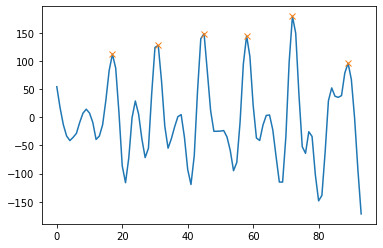

In [77]:
plt.plot(yhat)
plt.plot(peaks[0], yhat[peaks[0]], 'x')

(array([17, 31, 45, 58, 72, 89]), {'peak_heights': array([112.15763403, 127.68968531, 148.56643357, 144.9775641 ,
       179.48317308,  96.12339744]), 'prominences': array([153.49803322, 243.78758741, 263.61727855, 239.79632867,
       298.80674534, 244.52760781]), 'left_bases': array([ 4, 21, 41, 54, 41, 80]), 'right_bases': array([21, 41, 69, 69, 93, 93])})


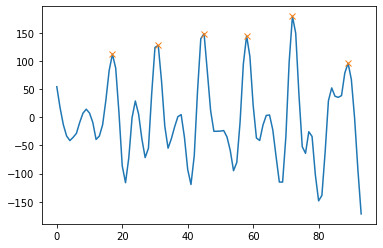

In [81]:
peaks = scipy.signal.find_peaks(yhat, height=iqr, prominence=4)
print(peaks)
plt.plot(yhat)
plt.plot(peaks[0], yhat[peaks[0]], 'x')

In [83]:
H_walk_wrist = loadwalkingdata('group_H-person_TOM-position_Wrist-Walking30.csv')
H_climb_wrist = loadwalkingdata('group_H-person_TOM-position_Wrist-Climbing30.csv')
H_descend_wrist = loadwalkingdata('group_H-person_TOM-position_Wrist-Descending30.csv')

---- loading group_H-person_TOM-position_Wrist-Walking30.csv
PDIoT walking data"
Start time: 20190923T153337"
Group: H"
Subject: tom"
Activity type: Walking (level ground)"
Sensor position: Wrist"
Side of body: Left"
Sensor mounting: Body"
Number of steps: 30"
Notes: "
----
---- loading group_H-person_TOM-position_Wrist-Climbing30.csv
PDIoT walking data"
Start time: 20190923T154047"
Group: H"
Subject: tom"
Activity type: Climbing stairs"
Sensor position: Wrist"
Side of body: Left"
Sensor mounting: Body"
Number of steps: 30"
Notes: "
----
---- loading group_H-person_TOM-position_Wrist-Descending30.csv
PDIoT walking data"
Start time: 20190923T154544"
Group: H"
Subject: tom"
Activity type: Descending stairs"
Sensor position: Wrist"
Side of body: Left"
Sensor mounting: Body"
Number of steps: 30"
Notes: "
----


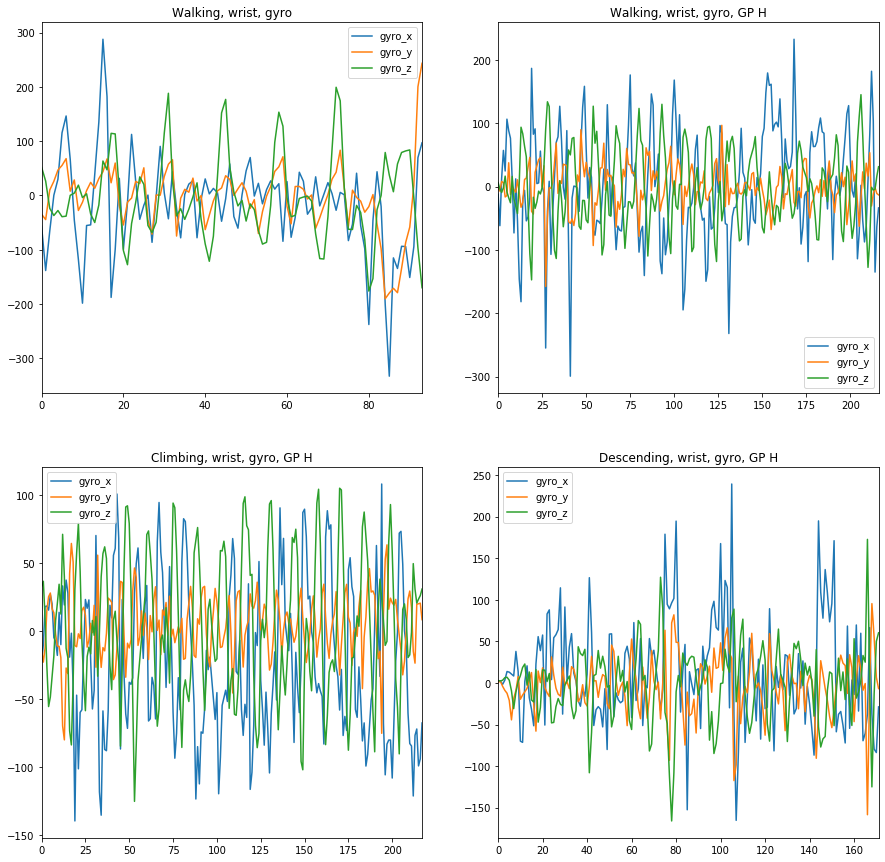

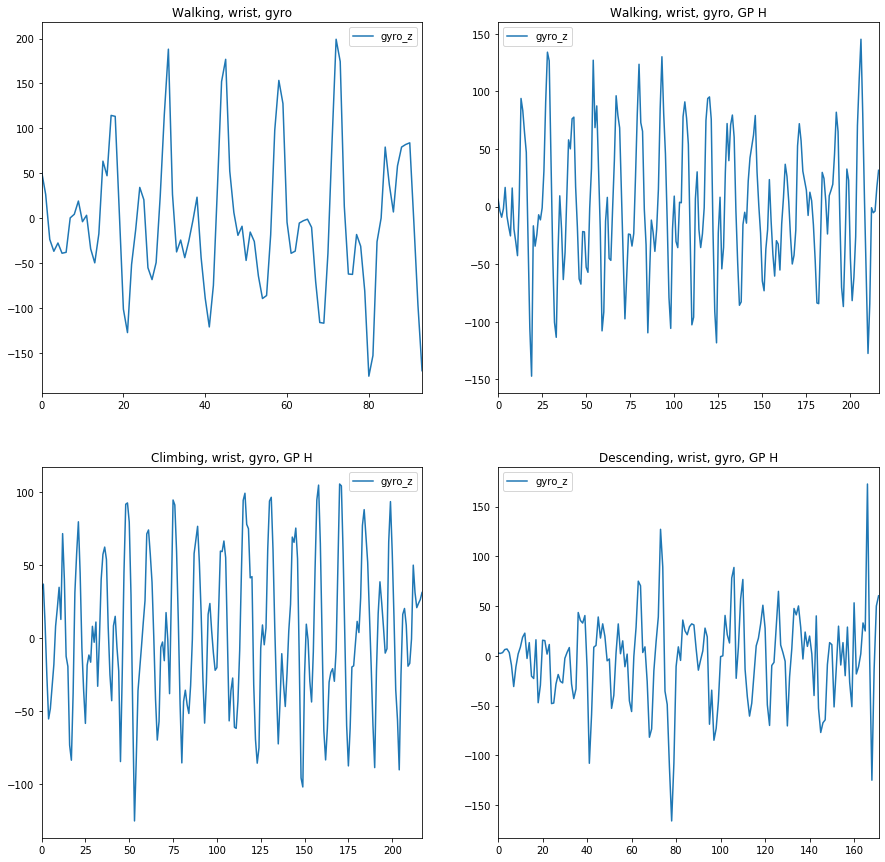

In [112]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
fig.title = "All gyro axes"

walk_wrist.plot(y=['gyro_x', 'gyro_y', 'gyro_z'], ax=axes[0,0], title="Walking, wrist, gyro")
H_walk_wrist.plot(y=['gyro_x', 'gyro_y', 'gyro_z'], ax=axes[0,1], title="Walking, wrist, gyro, GP H")
H_climb_wrist.plot(y=['gyro_x', 'gyro_y', 'gyro_z'], ax=axes[1,0], title="Climbing, wrist, gyro, GP H")
H_descend_wrist.plot(y=['gyro_x', 'gyro_y', 'gyro_z'], ax=axes[1,1], title="Descending, wrist, gyro, GP H")


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
fig.title = "Just gyro_z"

walk_wrist.plot(y=['gyro_z'], ax=axes[0,0], title="Walking, wrist, gyro")
H_walk_wrist.plot(y=['gyro_z'], ax=axes[0,1], title="Walking, wrist, gyro, GP H")
H_climb_wrist.plot(y=['gyro_z'], ax=axes[1,0], title="Climbing, wrist, gyro, GP H")
H_descend_wrist.plot(y=['gyro_z'], ax=axes[1,1], title="Descending, wrist, gyro, GP H")

In [113]:
def prepdata(data, axes):
    filtered = scipy.signal.savgol_filter(data, 9, 4)
    iqr = scipy.stats.iqr(filtered)*0.75
    print(iqr)
    allpeaks = scipy.signal.find_peaks(filtered)
    peaks = scipy.signal.find_peaks(filtered, height=iqr, prominence=4)
    axes.plot(filtered)
    axes.plot(allpeaks[0], filtered[allpeaks[0]], 'x', color='yellow')
    axes.plot(peaks[0], filtered[peaks[0]], 'x', color='red')
    return peaks

59.68151770105088
53.78930834790383
31.927160729896116
56.22470498251927


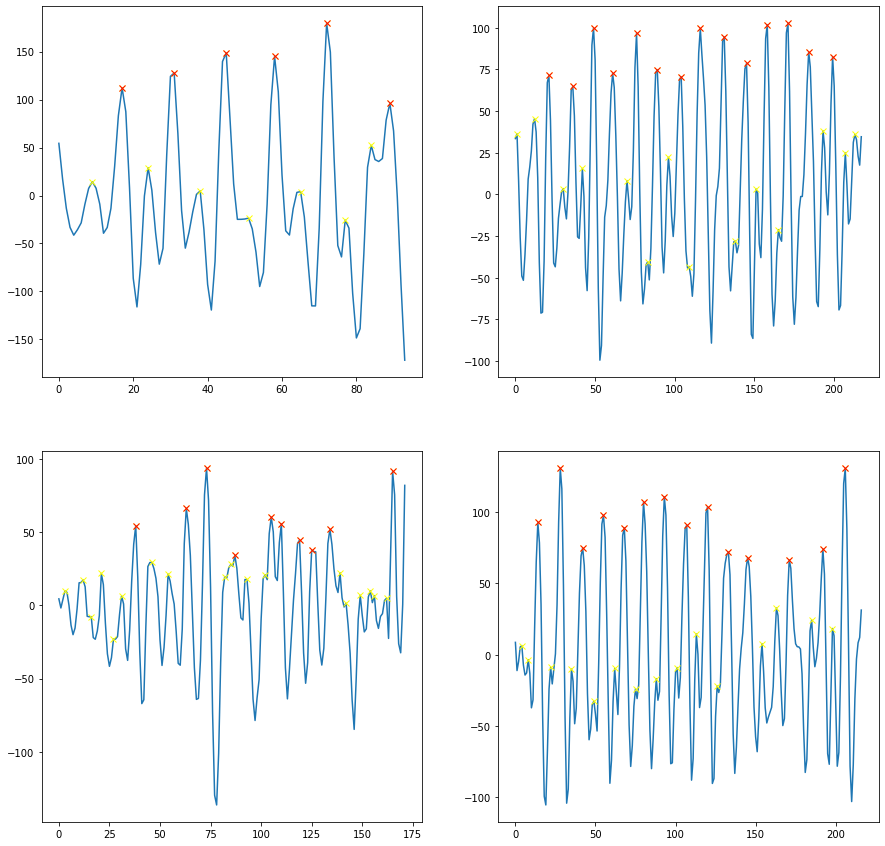

In [114]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
peaks1 = prepdata(walk_wrist['gyro_z'], axes[0,0])
peaks2 = prepdata(H_climb_wrist['gyro_z'], axes[0,1])
peaks3 = prepdata(H_descend_wrist['gyro_z'], axes[1,0])
peaks4 = prepdata(H_walk_wrist['gyro_z'], axes[1,1])

Wait, the lower peaks are also steps, just on the other foot... oh yikes

In [109]:
print(len(peaks1[0]))
print(len(peaks2[0]))
print(len(peaks3[0]))
print(len(peaks4[0]))

6
14
10
14
